enriched_iron_250um_26h.txt_26.txt


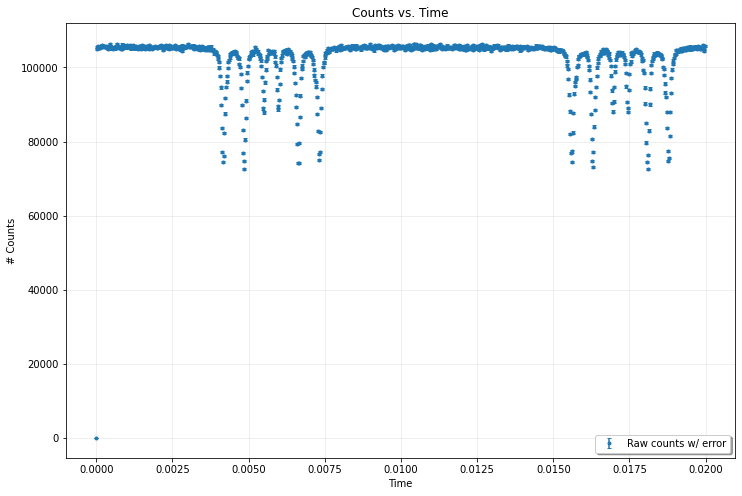

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import optimize
from scope_fit_11_22 import scope_fit
import scipy.constants as const
import re

folder_name = "enriched_iron_250um/"

# Get data from highest numbered file
file_ending = '.txt'
file_list = [file for file in os.listdir(folder_name) if file.endswith(file_ending)]
highest_numbered_file = sorted(file_list, key=lambda file: int(re.findall('[0-9]+.txt', file).pop()[:-4])).pop()
print(highest_numbered_file) # Make sure this is the right file
time_arr, total_count_arr = np.loadtxt(folder_name + highest_numbered_file, delimiter='\t', skiprows=5, unpack=True)

# Plot data to check where fits need to happen
fig1, ax1 = plt.subplots(figsize=(12, 8))
ax1.errorbar(time_arr, total_count_arr, yerr=np.sqrt(total_count_arr), label='Raw counts w/ error', fmt='.', capsize=2)
ax1.set_title('Counts vs. Time')
ax1.set_yscale("linear")
ax1.set_xscale("linear")
ax1.set_xlabel('Time')
ax1.set_ylabel('# Counts')
ax1.legend(framealpha=1, shadow=True, loc='best')
ax1.grid(alpha=0.25)
fig1.savefig('{}/{}_counts_time.png'.format(folder_name[:-1], folder_name[:-1]))
fig1.show()
plt.pause(0.001)
# input("hit[enter] to close/continue all plots")
# plt.close('all')
# exit()

In [17]:
# Inspect peaks and define positions
number_peaks = 12

fit_range = np.asarray([(0.0001, 0.0035), (0.0035, 0.0045), (0.0045, 0.0057), (0.0055, 0.0065), (0.0065, 0.0075), (0.0075, 0.0125), (0.01, 0.0155), (0.0155, 0.0165), (0.0164, 0.0173), (0.0172, 0.0183), (0.0185, 0.0195), (0.0190, 0.0200)])
approximate_positions = np.asarray([0.003, 0.004, 0.0054, 0.0062, 0.007, 0.0085, 0.0145, 0.0160, 0.0170, 0.0177, 0.0180, 0.0199])
approximate_amplitude = np.asarray([-2500, -1800, -1000, -1000, -1800, -2500, -2500, -1800, -1000, -1300, -1800, -2500])
approximate_width = np.asarray([0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0001, 0.0005, 0.0005])

approximate_offset = 23000 * np.ones(number_peaks)

param_matrix = np.transpose(np.vstack((approximate_positions, approximate_amplitude, approximate_width, approximate_offset)))

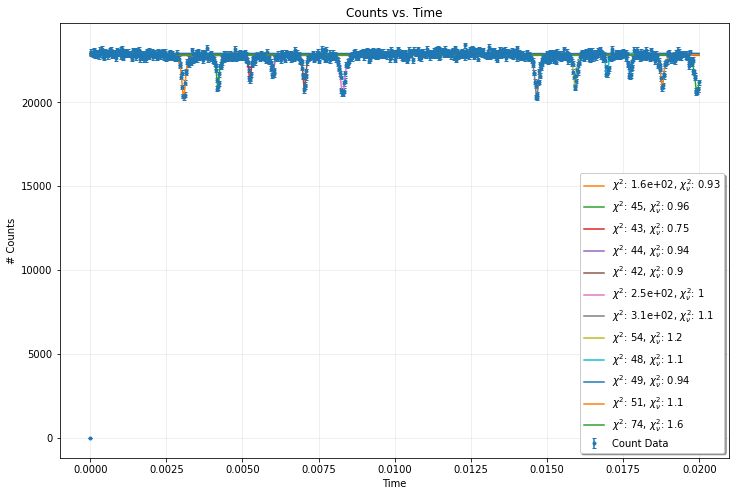

In [18]:
# Define and fit Lorentzian
def lorentzian(data, E0, amplitude, Gamma, offset):
  return amplitude * (Gamma / ((data - E0)**2 + (Gamma / 2)**2)) + offset

def lorentzian_sum(data, param_matrix):
  count = 0
  # Change normalize offset guess
  param_matrix[: , -1] = param_matrix[:, -1] / np.shape(param_matrix)[0]
  for row in param_matrix:
    count =+ lorentzian(data, *row)
  return count

opt_param_matrix = np.zeros(np.shape(param_matrix))
cov_matrix = np.zeros(shape=(np.shape(param_matrix)[0], np.shape(param_matrix)[1], np.shape(param_matrix)[1]))
chi2_matrix = np.zeros(shape=(number_peaks, 2))

for index in range(number_peaks):
  # print(index)
  # if index == 8:
  #   continue
  time_to_fit = [time for time in time_arr if time >= min(fit_range[index]) and time <= max(fit_range[index])]
  start_index = np.where(time_arr == time_to_fit[0])[0][0]
  stop_index =  np.where(time_arr == time_to_fit[-1])[0][0] + 1
  counts_to_fit = total_count_arr[start_index:stop_index]
  count_std_dev = np.sqrt(counts_to_fit) # Poission process has variance lambda
  opt_param_matrix[index], cov_matrix[index] = optimize.curve_fit(lorentzian, time_to_fit, counts_to_fit, param_matrix[index], sigma=count_std_dev)
  chi2 = np.sum(np.square(np.divide(np.subtract(counts_to_fit, lorentzian(time_to_fit, *opt_param_matrix[index])), count_std_dev)))
  deg_of_freedom = len(time_to_fit) - np.shape(param_matrix)[1]
  reduced_chi2 = chi2 / deg_of_freedom
  chi2_matrix[index] = [chi2, reduced_chi2]

# Fit a sum of lorentzians
num_groups = 2
sum_param_marix = np.zeros(np.shape(param_matrix))
sum_cov_matrix = np.zeros(shape=(np.shape(param_matrix)[0], np.shape(param_matrix)[1], np.shape(param_matrix)[1]))
sum_chi2_marix = np.zeros(shape=(number_peaks, 2))
group_index_list = [(0, 5), (5, 11)]
sum_fit_range = [(0.001, 0.0125), (0.01, 0.02)]

# for index_group in group_index_list:
  # sum_param_matrix[index], sum_cov_matrix[index] = optimize.curve_fit(lorentzian_sum, time_to_fit, counts_to_fit, param_matrix[index], sigma=count_std_dev)


# Plot data to check fits
fig2, ax2 = plt.subplots(figsize=(12, 8))
ax2.errorbar(time_arr, total_count_arr, yerr = np.sqrt(total_count_arr), capsize=2, label='Count Data', fmt='.')
time_points = np.linspace(min(time_arr), max(time_arr), 10000)
for index in range(number_peaks):
  ax2.plot(time_points, lorentzian(time_points, *opt_param_matrix[index]), label=r'$\chi^2$: {:.2g}, $\chi^2_{{\nu}}$: {:.2g}'.format(*chi2_matrix[index]))
ax2.set_title('Counts vs. Time')
ax2.set_yscale("linear")
ax2.set_xscale("linear")
ax2.set_xlabel('Time')
ax2.set_ylabel('# Counts')
ax2.legend(framealpha=1, shadow=True, loc='best')
ax2.grid(alpha=0.25)
fig2.savefig('{}/{}_counts_time_fit.png'.format(folder_name[:-1], folder_name[:-1]))
fig2.show()
# input("hit[enter] to close/continue")
# plt.close('all')
# exit()

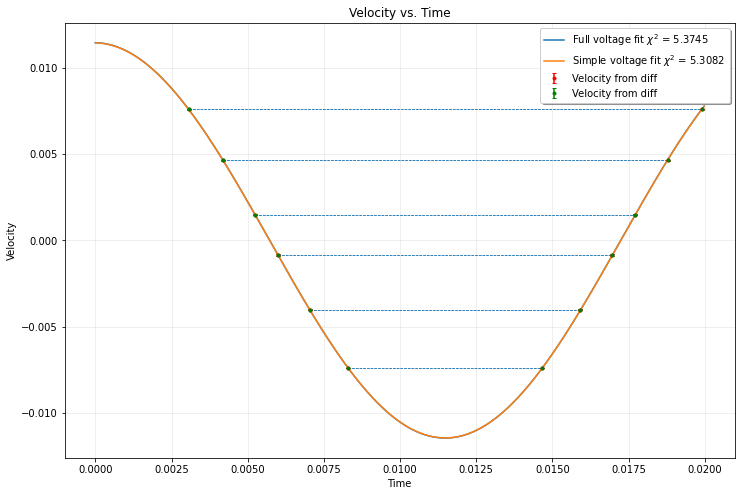

In [19]:
# Get velocity for peak through difference
num_distinct_peaks = int(number_peaks/2)
(full_amp, full_ang_freq, full_phase, full_shift), (simple_amp, simple_ang_freq)  = scope_fit.cos_params_from_data(plot=False)
velocity_voltage_ratio=0.080523086265892;
peak_velocity_matrix = np.zeros((num_distinct_peaks, 5))
# print('Opt param matrix[0]: \n{}'.format(opt_param_matrix))
for index in range(num_distinct_peaks):
  left_peak_time = opt_param_matrix[index][0]
  left_peak_uncertain = np.sqrt(np.diag(cov_matrix[index]))[2]
  right_peak_time = opt_param_matrix[-index - 1][0]
  right_peak_uncertain = np.sqrt(np.diag(cov_matrix[-index - 1]))[2]
  # print('Left peak time: {}, right peak time: {}'.format(left_peak_time, right_peak_time))
  time_diff = right_peak_time - left_peak_time
  time_diff_min = (right_peak_time - right_peak_uncertain) - (left_peak_time + left_peak_uncertain)
  time_diff_max = (right_peak_time + right_peak_uncertain) - (left_peak_time - left_peak_uncertain)
  # print('time diff: {}, min: {}, max: {}'.format(time_diff, time_diff_min, time_diff_max))
  full_voltage_from_diff = scope_fit.voltage_from_time_diff(time_diff, full_amp, full_ang_freq)
  simple_voltage_from_diff = scope_fit.voltage_from_time_diff(time_diff, simple_amp, simple_ang_freq)
  simple_voltage_max = scope_fit.voltage_from_time_diff(time_diff_min, simple_amp, simple_ang_freq)
  simple_voltage_min = scope_fit.voltage_from_time_diff(time_diff_max, simple_amp, simple_ang_freq)
  simple_velocity_uncertainty = velocity_voltage_ratio * abs(simple_voltage_max - simple_voltage_min) / 2
  # print('Velocity uncertainty: {}'.format(simple_velocity_uncertainty))
  # Using the peak for the two fits
  full_peak_velocity = full_voltage_from_diff * velocity_voltage_ratio
  simple_peak_velocity = simple_voltage_from_diff * velocity_voltage_ratio
  # print('velocity_uncertain: {:.2f}'.format(right_peak_uncertain + left_peak_uncertain))
  peak_velocity_matrix[index] = [full_peak_velocity, simple_peak_velocity, left_peak_time, right_peak_time, simple_velocity_uncertainty]

# Fit the full and simple trig function to these velocities
time_points = np.hstack((peak_velocity_matrix[:, 2], peak_velocity_matrix[:, 3]))
full_velocity_points = np.hstack((peak_velocity_matrix[:, 0], peak_velocity_matrix[:, 0]))
simple_velocity_points = np.hstack((peak_velocity_matrix[:, 1], peak_velocity_matrix[:, 1]))
velocity_error = np.hstack((peak_velocity_matrix[:, 4], peak_velocity_matrix[:, 4]))

def full_velocity(time, phase, shift):
  return velocity_voltage_ratio * full_amp * np.cos(full_ang_freq * time + phase) + shift

full_param_list, _ = optimize.curve_fit(full_velocity, time_points, full_velocity_points, p0=[0, 0])
full_chi2 = np.sum(np.square(np.divide(np.subtract(full_velocity_points, full_velocity(time_points, *full_param_list)), velocity_error)))

def simple_velocity(time, phase):
  return velocity_voltage_ratio * simple_amp * np.cos(simple_ang_freq * time + phase)

simple_phase, simple_cov = optimize.curve_fit(simple_velocity, time_points, simple_velocity_points, p0=[-0.1], sigma=velocity_error)
simple_chi2 = np.sum(np.square(np.divide(np.subtract(simple_velocity_points, simple_velocity(time_points, *simple_phase)), velocity_error)))
simple_chi2_no_phase = np.sum(np.square(np.divide(np.subtract(simple_velocity_points, simple_velocity(time_points, 0)), velocity_error)))

# print('Simple phase: {}, simple_cov: {}, phase_standard_dev: {}'.format(simple_phase, simple_cov, np.sqrt(np.diag(simple_cov))))
simple_phase_error = np.sqrt(np.diag(simple_cov))[0]

# Check fit to these points
fig3, ax3 = plt.subplots(figsize=(12, 8))

# Plot the velocity-time points given by the difference function
ax3.errorbar(x=time_points, y=full_velocity_points, yerr=velocity_error, label='Velocity from diff', color='red', fmt='.', capsize=2)
ax3.hlines(peak_velocity_matrix[:, 0], peak_velocity_matrix[:, 2], peak_velocity_matrix[:, 3], ls='dashed', lw=0.7)
ax3.errorbar(x=time_points, y=simple_velocity_points, yerr=velocity_error, label='Velocity from diff', color='green', fmt='.', capsize=2)
ax3.hlines(peak_velocity_matrix[:, 1], peak_velocity_matrix[:, 2], peak_velocity_matrix[:, 3], ls='dashed', lw=0.7)

# Plot the functions
time_points = np.linspace(min(time_arr), max(time_arr), 10000)
ax3.plot(time_points, full_velocity(time_points, *full_param_list), label=r'Full voltage fit $\chi^2$ = {:.4f}'.format(full_chi2))
ax3.plot(time_points, simple_velocity(time_points, simple_phase), label=r'Simple voltage fit $\chi^2$ = {:.4f}'.format(simple_chi2))

ax3.set_title('Velocity vs. Time')
ax3.set_yscale("linear")
ax3.set_xscale("linear")
ax3.set_xlabel('Time')
ax3.set_ylabel('Velocity')
ax3.legend(framealpha=1, shadow=True, loc='best')
ax3.grid(alpha=0.25)
# Save .png of plot to folder with file
fig3.savefig('{}/{}_vel_phase_check.png'.format(folder_name[:-1], folder_name[:-1]))
fig3.show()
# input("hit[enter] to close/continue\n")
# plt.close('all')
# exit()

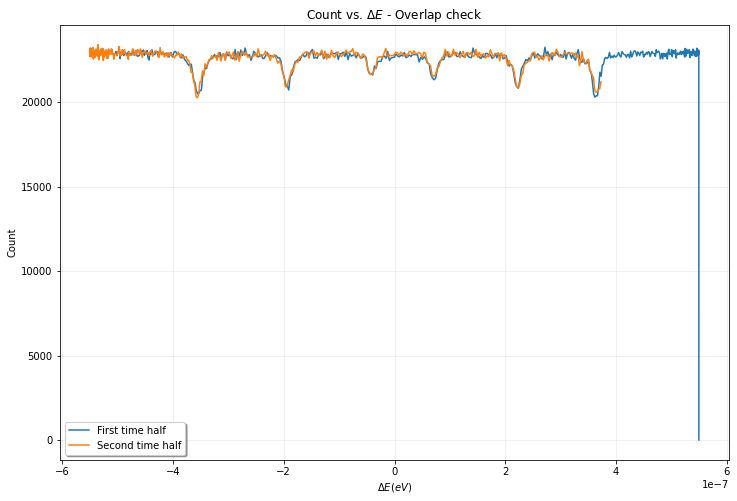

In [20]:
# Map time to energy shift through velocity
gamma_energy = 14.41 * 1000 * const.electron_volt
def energy_shift_from_time(time, phase=0):
  velocity = simple_velocity(time, *simple_phase + phase)
  shift = (velocity / const.speed_of_light) * gamma_energy
  return np.asarray(shift / const.electron_volt)

# Check if the energy dips are overlapping
half_values = int(len(time_arr) / 2)

time_arr_1 = time_arr[:half_values]
time_arr_2 = time_arr[half_values:]
count_arr_1 = total_count_arr[:half_values]
count_arr_2 = total_count_arr[half_values:]

# time_arr_1, time_arr_2 = np.split(time_arr, 2)
# count_arr_1, count_arr_2 = np.split(total_count_arr, 2)

fig4, ax4 = plt.subplots(figsize=(12, 8))
ax4.plot(energy_shift_from_time(time_arr_1) , count_arr_1, label='First time half')
ax4.plot(energy_shift_from_time(time_arr_2), count_arr_2, label='Second time half')
ax4.set_title(r'Count vs. $\Delta E$ - Overlap check')
ax4.set_yscale("linear")
ax4.set_xscale("linear")
ax4.set_xlabel(r'$\Delta E (eV)$')
ax4.set_ylabel('Count')
ax4.legend(framealpha=1, shadow=True, loc='best')
ax4.grid(alpha=0.25)
# Save .png of plot to folder with file
fig4.savefig('{}/{}_energy_shift_overlap.png'.format(folder_name[:-1], folder_name[:-1]))
fig4.show()
# input("hit[enter] to close all plots")
# plt.close('all')
# exit()

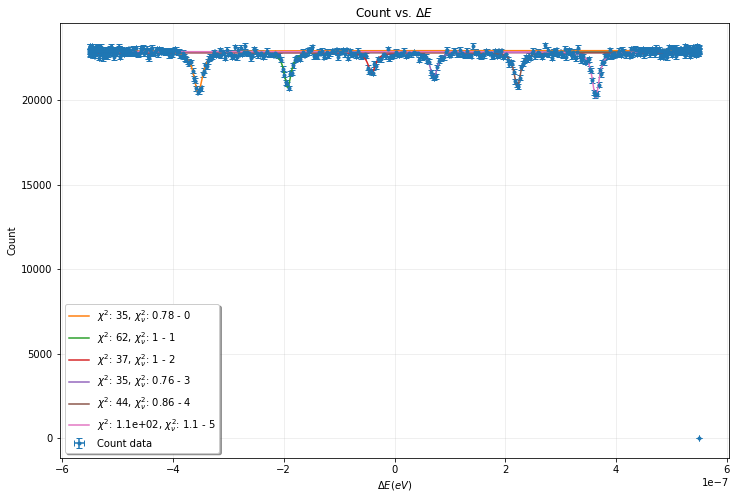

In [21]:
# Convert lorentzian parameters from earlier estimate
energy_param_matrix = opt_param_matrix[:num_distinct_peaks, :]
energy_param_matrix[:, 0] = energy_shift_from_time(energy_param_matrix[:, 0]) 
energy_param_matrix[:, 2] = energy_shift_from_time(energy_param_matrix[:, 2]) 
energy_range = np.asarray([(energy_shift_from_time(time[0]), energy_shift_from_time(time[1])) for time in fit_range[:num_distinct_peaks]])

# Update parameters if needed
# energy_range = pow(10, -7) * np.asarray([(-4.5, -3.5), (-2.8, -1), (-1, 0.2), (0, 1.5), (1.5, 3), (3, 5)])
# energy_param_matrix[:, 0] = approximate_positions = pow(10, -7) * np.asarray([-3.5, -2, -0.5 , 0.7 , 2 , 3.8])
# energy_param_matrix[:, 2] = approximate_width = pow(10, -7) * np.asarray([0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

# Get rid of duplicate energy values - assuming concave up at all times
energy_shift_list = np.asarray(energy_shift_from_time(time_arr))
unique_shift_list = energy_shift_list[0:energy_shift_list.argmin()]
unique_time_list = time_arr[:np.shape(unique_shift_list)[0]]
unique_count_list = total_count_arr[:np.shape(unique_shift_list)[0]]

# Perform fit like earlier, but to the energy data
opt_energy_param_matrix = np.zeros(np.shape(energy_param_matrix))
energy_cov_matrix = np.zeros(shape=(np.shape(energy_param_matrix)[0], np.shape(energy_param_matrix)[1], np.shape(energy_param_matrix)[1]))
chi2_matrix = np.zeros(shape=(num_distinct_peaks, 2))
for index in range(num_distinct_peaks):
  # if index == 3 or index == 4:
  #   continue
  energy_to_fit = [energy for energy in unique_shift_list if energy >= min(energy_range[index]) and energy <= max(energy_range[index])]
  start_index = np.where(unique_shift_list == energy_to_fit[0])[0][0]
  stop_index =  np.where(unique_shift_list == energy_to_fit[-1])[0][0] + 1
  counts_to_fit = total_count_arr[start_index:stop_index]
  count_std_dev = np.sqrt(counts_to_fit) # Poission process has variance lambda
  opt_energy_param_matrix[index], energy_cov_matrix[index] = optimize.curve_fit(lorentzian, energy_to_fit, counts_to_fit, energy_param_matrix[index], sigma=count_std_dev)
  chi2 = np.sum(np.square(np.divide(np.subtract(counts_to_fit, lorentzian(energy_to_fit, *opt_energy_param_matrix[index])), count_std_dev)))
  deg_of_freedom = len(energy_to_fit) - np.shape(energy_param_matrix)[1]
  reduced_chi2 = chi2 / deg_of_freedom
  chi2_matrix[index] = [chi2, reduced_chi2]

# Assuming errors are symmetric
xerr = energy_shift_from_time(unique_time_list, simple_phase_error) - unique_shift_list
yerr = np.sqrt(unique_count_list)
energy_points = np.linspace(min(unique_shift_list), max(unique_shift_list), 10000)

fig5, ax5 = plt.subplots(figsize=(12, 8))
ax5.errorbar(unique_shift_list, unique_count_list, yerr=yerr, xerr=xerr, fmt='.', capsize=3, label='Count data')
for index in range(num_distinct_peaks):
  ax5.plot(energy_points, lorentzian(energy_points, *opt_energy_param_matrix[index]), label=r'$\chi^2$: {:.2g}, $\chi^2_{{\nu}}$: {:.2g} - {}'.format(*chi2_matrix[index], index))
ax5.set_title(r'Count vs. $\Delta E$')
ax5.set_yscale("linear") 
ax5.set_xscale("linear")
ax5.set_xlabel(r'$\Delta E (eV)$')
ax5.set_ylabel('Count')
ax5.legend(framealpha=1, shadow=True, loc='best')
ax5.grid(alpha=0.25)
# Save .png of plot to folder with file
fig5.savefig('{}/{}_energy_shift_vs_count.png'.format(folder_name[:-1], folder_name[:-1]))
fig5.show()
# input("hit[enter] to close all plots")
# plt.close('all')

# Write lorentzian data into .csv file
with open(folder_name + folder_name[:-1] + '.csv', 'w') as f:
  f.write('Position, Amplitude, Width, Vertical Offset, Position std, Amplitude std, Width std, Offset std\n')
  for index in range(num_distinct_peaks):
    f.write(np.array2string(opt_energy_param_matrix[index], separator=',', prefix='', suffix=''))
    f.write(', ')
    f.write(np.array2string(np.sqrt(np.diagonal(energy_cov_matrix[index])), separator=',', prefix='', suffix=''))
    f.write('\n')



In [22]:
# TODO: Using panda dataframes with named columns would make things easier
# TODO: Take x-error into account when fitting energy
# TODO: Vectorize with numpy
# TODO: Compute Isomer shifts - peak average diff from 0
# TODO: Add the counts for same energy
# TODO: Get uncertainties for the energy
# TODO: Get rid of separating unique energies - or only care about unique energies after overlap confirmed

# # Add counts for 'same' energy


# def find_nearest(array, value, search_start):
#     idx = (np.abs(array[search_start:] - value)).argmin()
#     return array[idx]

# for index, shift in enumerate(np.array_split(energy_shift_list, 2)[0]):
#   nearest_shift = find_nearest(energy_shift_list, shift, index + 1)
#   # print('shift: {}, nearest shift: {}'.format(shift, nearest_shift))

# We also want to fit a Lorentzian to that to get the drop in energy

# print('Position, Amplitude, Width, Vertical Offset')
# # printf('Position, Amplitude, Width, Vertical Offset')
# for index in range(num_distinct_peaks):
#   print(opt_energy_param_matrix[index])
#   print(np.sqrt(np.diagonal(energy_cov_matrix[index])))